In [4]:
import pandas as pd
import numpy as np
import requests
import io

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error

from IPython.display import display

## Preparing the Dataset

In [5]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

In [6]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
# transform columns to snake case
df.columns = df.columns.str.lower().str.replace(' ', '_')

# transform string data to snake case
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [9]:
base = [
    'lead_source',
    'industry',
    'number_of_courses_viewed',
    'annual_income',
    'employment_status',
    'location',
    'interaction_count',
    'lead_score',
    'converted'
]

df = df[base]

In [10]:
# --- 1. Define Column Groups based on Data Type ---
# We infer the data type from the column names and context:

# Categorical columns with missing values
categorical_colums = ['lead_source', 'industry', 'employment_status', 'location']

# Numerical columns with missing values
# 'annual_income' is the only numerical column with missing values
numerical_colums = ['annual_income']

# --- 2. Impute Missing Values According to Instructions ---

print("--- Starting Imputation ---")

# A. Impute Categorical Columns with 'NA'
for c in categorical_colums:
    if c in df.columns:
        # Fill NaN values with the string 'NA'
        df[c].fillna('NA', inplace=True)
        print(f"Filled missing values in '{c}' with 'NA'.")
    else:
        print(f"Warning: Column '{c}' not found in DataFrame.")

# B. Impute Numerical Columns with 0.0
for c in numerical_colums:
    if c in df.columns:
        # Fill NaN values with the float 0.0
        df[c].fillna(0.0, inplace=True)
        print(f"Filled missing values in '{c}' with 0.0.")
    else:
        print(f"Warning: Column '{c}' not found in DataFrame.")


print("\n--- Verification: Missing values after cleaning ---")
# Check the missing counts again to confirm the operation was successful
print(df.isnull().sum())

--- Starting Imputation ---
Filled missing values in 'lead_source' with 'NA'.
Filled missing values in 'industry' with 'NA'.
Filled missing values in 'employment_status' with 'NA'.
Filled missing values in 'location' with 'NA'.
Filled missing values in 'annual_income' with 0.0.

--- Verification: Missing values after cleaning ---
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


C:\Users\KGOMOTSO MONGALE\AppData\Local\Temp\ipykernel_9320\3645104816.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna('NA', inplace=True)
C:\Users\KGOMOTSO MONGALE\AppData\Local\Temp\ipykernel_9320\3645104816.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

## Question 1
What is the most frequent observation (mode) for the column industry?

In [21]:
df.industry.value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

In [22]:
print(f"The most frequent value (mode) in the 'industry' column is {df.industry.mode()[0]}.")

The most frequent value (mode) in the 'industry' column is retail.


## Question 2
- Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- interaction_count and lead_score
- number_of_courses_viewed and lead_score
- number_of_courses_viewed and interaction_count
- annual_income and interaction_count
- Only consider the pairs above when answering this question.

Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.

In [13]:
numerical=['number_of_courses_viewed',
           'annual_income',
           'interaction_count',
           'lead_score',
           'converted'
]
df_numerical = df[numerical]

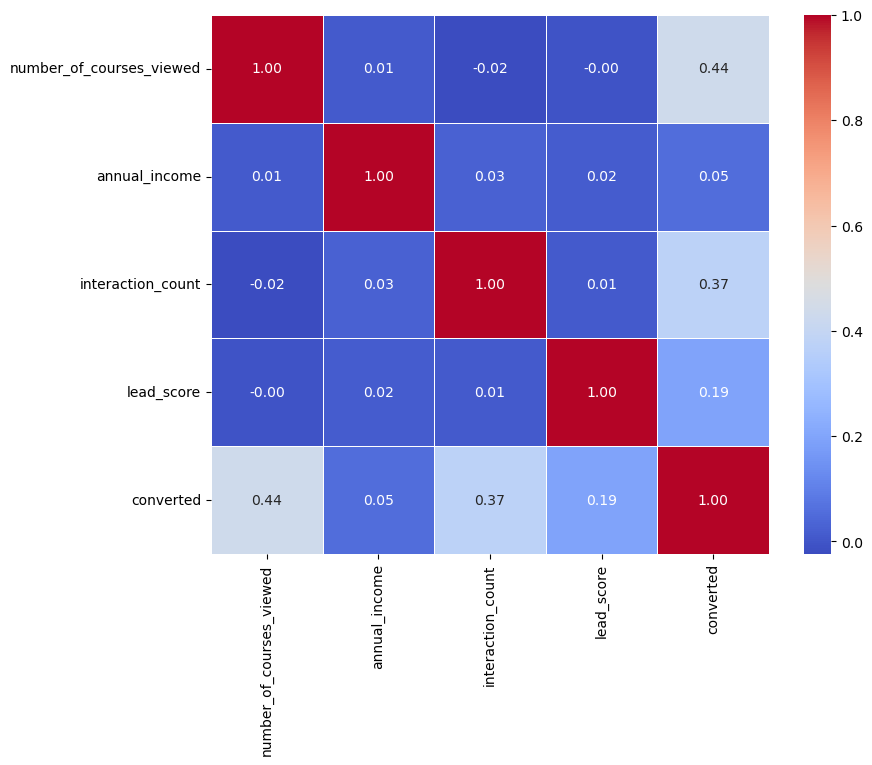

In [14]:
plt.figure(figsize=(9, 7))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [16]:
print(f"The two features that have the biggest correlation are 'annual_income' and 'interaction_count'.")

The two features that have the biggest correlation are 'annual_income' and 'interaction_count'.


## Split the Data

In [19]:
X = df.drop(columns=['converted'])
y = df['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

(877, 292, 293)

## Question 3
- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

In [23]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [24]:
def mutual_info_y_score(series):
    return mutual_info_score(series, y_train)

In [25]:
mi = X_train[categorical].apply(mutual_info_y_score)
mi.sort_values(ascending=False).round(2)

lead_source          0.03
employment_status    0.02
industry             0.02
location             0.00
dtype: float64

In [26]:
print(f"The variable with the highest mutual information is 'lead_source'.")

The variable with the highest mutual information is 'lead_source'.


## Question 4
Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
- - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
- - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [28]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [29]:
categorical, categorical_features

(['lead_source', 'industry', 'employment_status', 'location'],
 ['lead_source', 'industry', 'employment_status', 'location'])

In [30]:
numerical, numerical_features

(['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score',
  'converted'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set is: {validation_accuracy:.2f}')

 The accuracy on the validation set is: 0.86


## Question 5
- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

## All Features

In [41]:
Q5 = ['industry', 'employment_status', 'lead_score', 'converted']

dfq5 = df[Q5].copy()
X = dfq5.drop(columns=['converted'])
y = dfq5['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_all = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features is: {validation_accuracy_all:.2f}')

 The accuracy on the validation set of all features is: 0.60


## All Features but industry

In [42]:
Q5 = ['employment_status', 'lead_score', 'converted']

dfq5 = df[Q5]
X = dfq5.drop(columns=['converted'])
y = dfq5['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_industry = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but industry is: {validation_accuracy_industry:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_industry}')

 The accuracy on the validation set of all features but industry is: 0.63
 The difference between accuracies is: -0.03082191780821919


## All Features but employment_status

In [48]:
Q5 = ['industry', 'lead_score', 'converted']

dfq5 = df[Q5]
X = dfq5.drop(columns=['converted'])
y = dfq5['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_employment_status = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but employment_status is: {validation_accuracy_employment_status:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_employment_status}')

 The accuracy on the validation set of all features but employment_status is: 0.63
 The difference between accuracies is: -0.03082191780821919


## All Features but lead_score

In [47]:
Q5 = ['industry', 'employment_status', 'converted']

dfq5 = df[Q5]
X = dfq5.drop(columns=['converted'])
y = dfq5['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_lead_score = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but lead_score is: {validation_accuracy_lead_score:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_lead_score}')

 The accuracy on the validation set of all features but lead_score is: 0.61
 The difference between accuracies is: -0.003424657534246589


In [45]:
df_accuracies = pd.DataFrame(
    [validation_accuracy_all, validation_accuracy_industry, validation_accuracy_employment_status, validation_accuracy_lead_score], 
    index=['all', 'industry', 'employment_status', 'lead_score'],
    columns=['validation_accuracy']
)

df_differences = pd.DataFrame(
    [validation_accuracy_all - validation_accuracy_all, 
     validation_accuracy_all - validation_accuracy_industry, 
     validation_accuracy_all - validation_accuracy_employment_status, 
     validation_accuracy_all - validation_accuracy_lead_score], 
    index=['all', 'industry', 'employment_status', 'lead_score'],
    columns=['difference_from_all']
)

df_result = pd.concat([df_accuracies, df_differences], axis=1)
df_result.sort_values(by='validation_accuracy', ascending=False)

,validation_accuracy,difference_from_all
industry,0.633562,-0.030822
employment_status,0.633562,-0.030822
lead_score,0.606164,-0.003425
all,0.602740,0.000000


## Question 6
- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [46]:
Q6 = ['industry', 'employment_status', 'lead_score', 'converted']

Cs = [0.01, 0.1, 1, 10, 100]
results = []

dfq6 = df[Q6].copy()
X = dfq6.drop(columns=['converted'])
y = dfq6['converted']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

for C in Cs:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42))
    ])
    
    pipeline.fit(X_train, y_train)
    validation_accuracy = pipeline.score(X_val, y_val)
    results.append({'C': C, 'Validation Accuracy': validation_accuracy})

results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by='Validation Accuracy', ascending=False)

sorted_results.round(3)

,C,Validation Accuracy
0,0.01,0.644
1,0.10,0.613
3,10.00,0.606
4,100.00,0.606
2,1.00,0.603
